In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz

In [75]:
columns = ['Capture_time', 'Id']
print('Reading CSV...')
print(datetime.datetime.now())

data = pd.read_csv('../evo_data_menor.csv', usecols=columns, nrows=30000000)

print(datetime.datetime.now())
print('Finish\n')

Reading CSV...
2018-09-01 18:18:44.094738
2018-09-01 18:19:40.591529
Finish



In [76]:
data.head()

,Capture_time,Id
0,2018-03-01 08:24:51.795031-08:00,JTDKDTB31J1599606
1,2018-03-01 08:24:51.795031-08:00,JTDKDTB31H1597557
2,2018-03-01 08:24:51.795031-08:00,JTDKDTB36E1079858
3,2018-03-01 08:24:51.795031-08:00,JTDKDTB33F1101042
4,2018-03-01 08:24:51.795031-08:00,JTDKDTB32G1118514


In [77]:
# Colleting vehicle ids
car_ids = list(data.Id.unique())

# Removing uncommon ids
# Ex: 4c5865a3-4b03-40f6-a3a8-d4e94aae3b17
ids_uncommon = [id for id in car_ids if id.find('-') != -1]
car_ids = [id for id in car_ids if id.find('-') == -1]

print('Data len before remove uncommon ids: '+str(len(data)))
data = data[~data.Id.isin(ids_uncommon)]
print('Data len after remove uncommon ids: '+str(len(data)))

Data len before remove uncommon ids: 30000000
Data len after remove uncommon ids: 29999500


In [3]:
def str_to_datetime(df_time):
    """ 
    Reformatando de string para datetime.
    
    Parameters
    ----------
    df_time : pandas.DataFrame, string
        Dataframe com strings a serem convertidas para datetime.
    
    Returns
    ----------
    date_list : pandas.DataFrame, datetime
        Dataframe com valores em datetime para possíveis fusos de Vancouver.
    
    """
    date_list = []
    
    # Formatos de fuso horário comum de Vancouver e 
    # fuso horário característico de horário de verão
    format_string = ['%Y-%m-%d %H:%M:%S.%f-08:00', '%Y-%m-%d %H:%M:%S.%f-07:00',
                     '%Y-%m-%d %H:%M:%S-08:00', '%Y-%m-%d %H:%M:%S-07:00']
    
    
    for date in df_time:
        for fmt in format_string:
            try:
                date_list.append(datetime.datetime.strptime(str(date), fmt))
                erro = False
                break
            except:
                pass
        if erro:
            print('Erro in: '+str(date))
            
    
    return pd.DataFrame(date_list)

In [79]:
print('Date strings to Datetime type\n')
data['Capture_time'] = str_to_datetime(data['Capture_time'])

Date strings to Datetime type



In [80]:
data.head()

,Capture_time,Id
0,2018-03-01 08:24:51.795031,JTDKDTB31J1599606
1,2018-03-01 08:24:51.795031,JTDKDTB31H1597557
2,2018-03-01 08:24:51.795031,JTDKDTB36E1079858
3,2018-03-01 08:24:51.795031,JTDKDTB33F1101042
4,2018-03-01 08:24:51.795031,JTDKDTB32G1118514


In [85]:
print(datetime.datetime.now())

data = data.sort_values(by='Capture_time')
# Series with each collected minute
dates = pd.Series(data.Capture_time.unique())
busy_weekdays = []
busy_weekends = []

# Going through each date in order to count the number of cars in travel.
for dt in dates:
    parked = len(data[data['Capture_time'] == dt])
    in_travel = len(car_ids) - parked
    percentage = (in_travel/len(car_ids))*100
    
    # Sorting out per week day
    if dt.weekday() <= 4: # Monday == 0 .. Sunday == 6
        busy_weekdays.append([int(dt.timestamp()), in_travel, percentage])
    else: 
        busy_weekends.append([int(dt.timestamp()), in_travel, percentage])
        

dfIn_Travel_weekdays = pd.DataFrame(busy_weekdays, columns=['capture_time', 'total_in_travel', 'percentage'])
dfIn_Travel_weekends = pd.DataFrame(busy_weekends, columns=['capture_time', 'total_in_travel', 'percentage'])

print(datetime.datetime.now())

2018-09-01 19:47:15.618899


In [4]:
def from_timestamp_list(timestamp_list):
    
    datetime_list = []
    
    for date in timestamp_list:
        datetime_list.append(datetime.datetime.fromtimestamp(int(date)))
    
    return pd.DataFrame(datetime_list)

In [73]:
# Formatando os dados de unix timestamp para datetime

dfWeekdays = dfIn_Travel_weekdays

dfWeekdays['capture_time'] = from_timestamp_list(dfWeekdays['capture_time'])    
    
    
dfWeekends = dfIn_Travel_weekends

dfWeekends['capture_time'] = from_timestamp_list(dfWeekends['capture_time'])

In [ ]:
# Plot da porcentagem de carros alocados em dias de semana
plt.plot(dfWeekdays['capture_time'],dfWeekdays['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# Plot da porcentagem de carros alocados em dias de final de semana
plt.plot(dfWeekends['capture_time'],dfWeekends['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

In [13]:
dfWeekends.to_csv('weekends.csv', index=False, encoding='utf-8')
dfWeekdays.to_csv('weekdays.csv', index=False, encoding='utf-8')

In [14]:
dfWeekdays = pd.read_csv('../evo-plots/weekdays.csv')
dfWeekends = pd.read_csv('../evo-plots/weekends.csv')

In [16]:
# Debug
dfWeekdays.capture_time = pd.to_datetime(dfWeekdays.capture_time)
dfWeekdays['minute'] = dfWeekdays.capture_time.dt.minute
dfWeekdays['hour'] = dfWeekdays.capture_time.dt.hour

In [19]:
# Outlier importante a ser verificado
dfWeekdays[(dfWeekdays.hour == 10) & (dfWeekdays.minute == 32)].describe()

,total_in_travel,percentage,minute,hour
count,109.000000,109.000000,109.0,109.0
mean,352.532110,28.023220,32.0,10.0
std,30.630283,2.434840,0.0,0.0
min,283.000000,22.496025,32.0,10.0
25%,331.000000,26.311606,32.0,10.0
50%,351.000000,27.901431,32.0,10.0
75%,373.000000,29.650238,32.0,10.0
max,430.000000,34.181240,32.0,10.0


In [17]:
dfWeekdays['capture_time'] = pd.to_datetime(dfWeekdays['capture_time'])
dfWeekends['capture_time'] = pd.to_datetime(dfWeekends['capture_time'])

In [18]:
def media(df): 
    """
    Faz a media das porcentagens minuto a minuto de todo o dataset.
    
    Parameters
    ------------
    df : Pandas dataframe
        Dados a serem analisados, com uma coluna dos horários e outra com as porcentagens.
    
    Returns
    ----------
    media : Pandas dataframe
        Dados com a média das porcentagens para 24 horas.
    
    """
    minute = []

    # Criando uma coluna que irá sinalizar a quantidade de minutos corridos até tal registro
    df['minute'] = df.capture_time.dt.minute + (df.capture_time.dt.hour * 60)
    
    # Ordenando o dataset por minutos corridos para facilitar a soma de valores
    df = df.sort_values(by=['minute', 'capture_time'])
    
    min_list = list(df['minute'].unique())
    media = []
    # É percorrido minuto a minuto para se obter a média de porcentagem para cada
    # Assim é formado um dataframe com média de utilização a cada minuto
    for min in min_list:

        occurencies = df[df.minute == min]
    
        media.append([occurencies.capture_time.iloc[0].strftime('%H:%M'), 
                      float(occurencies.percentage.mean()), 
                      float(occurencies.percentage.std())])
    

    media = pd.DataFrame(media, columns=['time', 'mean', 'std'])
    
    return media

In [19]:
# Fazendo a média das porcentagens de cada dia
print('Media')
print(datetime.datetime.now())

dfWeekdays = dfWeekdays.sort_values(by='capture_time')
mediaWeekdays = media(dfWeekdays)

dfWeekends = dfWeekends.sort_values(by='capture_time')
mediaWeekends = media(dfWeekends)
print(datetime.datetime.now())

Media
2018-10-25 19:30:42.756189
2018-10-25 19:30:46.718605


In [21]:
mediaWeekdays.to_csv('mediaWeekdays.csv', index=False, encoding='utf-8')
mediaWeekends.to_csv('mediaWeekends.csv', index=False, encoding='utf-8')

In [10]:
mediaWeekdays = pd.read_csv('../evo-plots/mediaWeekdays.csv')
mediaWeekends = pd.read_csv('../evo-plots/mediaWeekends.csv')

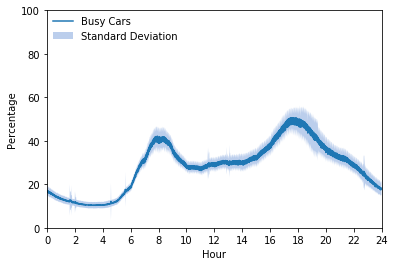

In [49]:

# Plot da media das porcentagens dos dias de semana
fig, ax = plt.subplots()
# Curva dos carros andando
ax.plot(range(len(mediaWeekdays['time'])),mediaWeekdays['mean'], label='Busy Cars')

# Curvas representando o intervalo de desvio padrão
# ax.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']+mediaWeekdays['std'], alpha=150, c='gray', label='Desvio Padrão')
# ax.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']-mediaWeekdays['std'], alpha=150, c='gray')

ax.fill_between(range(len(mediaWeekdays['time'])),mediaWeekdays['mean']+mediaWeekdays['std'], 
                mediaWeekdays['mean']-mediaWeekdays['std'], facecolor='#8faee0', alpha=0.6, label='Standard Deviation')

# Modificando os labels das horas
ax.xaxis.set_ticks(np.arange(0, 1441, 120))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Y axis between 0%-100%
ax.set_ylim([0,100])

ax.set_xlim([0,1441])

# Legendas e label dos eixos
plt.legend(loc=2, borderaxespad=0.2, frameon=False)
plt.ylabel('Percentage')
plt.xlabel('Hour')

# Salvando o plot
plt.savefig('../Weekdays.pdf', bbox_inches='tight')

plt.show()

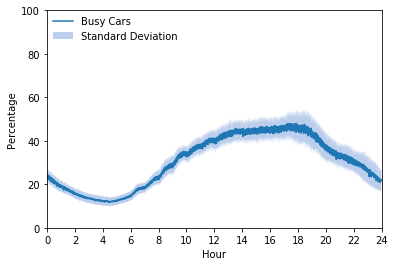

In [50]:

# Plot da media das porcentagens dos dias de semana
fig, ax = plt.subplots()
# Curva dos carros andando
ax.plot(range(len(mediaWeekends['time'])),mediaWeekends['mean'], label='Busy Cars')

# Curvas representando o intervalo de desvio padrão
# ax.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']+mediaWeekends['std'], alpha=150, c='gray', label='Desvio Padrão')
# ax.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']-mediaWeekends['std'], alpha=150, c='gray')

ax.fill_between(range(len(mediaWeekends['time'])),mediaWeekends['mean']+mediaWeekends['std'], 
                mediaWeekends['mean']-mediaWeekends['std'], facecolor='#8faee0', alpha=0.6, label='Standard Deviation')

# Modificando os labels das horas
ax.xaxis.set_ticks(np.arange(0, 1441, 120))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Y axis between 0%-100%
ax.set_ylim([0,100])

ax.set_xlim([0,1441])

# Legendas e label dos eixos
plt.legend(loc=2, borderaxespad=0.2, frameon=False)
plt.ylabel('Percentage')
plt.xlabel('Hour')

# Salvando o plot
plt.savefig('../Weekends.pdf', bbox_inches='tight')

plt.show()

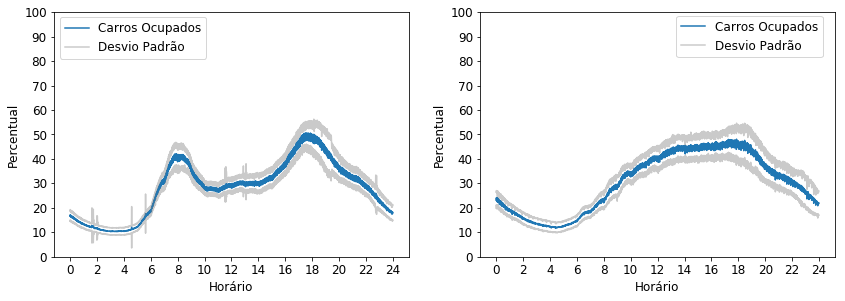

<Figure size 432x288 with 0 Axes>

In [16]:

matplotlib.rc('font', size=12)

# Plot das porcentagens dos fins de semana
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(14,4.5)



# Curva dos carros andando

ax1.plot(range(len(mediaWeekdays['time'])),mediaWeekdays['mean'], label='Carros Ocupados')

# Curvas representando o intervalo de desvio padrão
ax1.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']+mediaWeekdays['std'], alpha=150, c='gray', label='Desvio Padrão')
ax1.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']-mediaWeekdays['std'], alpha=150, c='gray')

# Modificando os labels das horas e das porcentagens
ax1.xaxis.set_ticks(np.arange(0, 1441, 120))
ax1.yaxis.set_ticks(np.arange(0, 110, 10))

fig.canvas.draw()

labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = range(0,26,2)

ax1.set_xticklabels(labels)

# Eixo y de 0 a 100%
ax1.set_ylim([0,100])

# Legendas e label dos eixos
ax1.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.2)
ax1.set_ylabel('Percentual')
ax1.set_xlabel('Horário')




# # Curva dos carros andando
ax2.plot(range(len(mediaWeekends['time'])),mediaWeekends['mean'], label='Carros Ocupados')

# # Curvas representando o intervalo de desvio padrão
ax2.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']+mediaWeekends['std'], alpha=150, c='gray', label='Desvio Padrão')
ax2.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']-mediaWeekends['std'], alpha=150, c='gray')

# Modificando os labels das horas e das porcentagens
ax2.xaxis.set_ticks(np.arange(0, 1441, 120))
ax2.yaxis.set_ticks(np.arange(0, 110, 10))

fig.canvas.draw()

labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = range(0,26,2)

ax2.set_xticklabels(labels)

# Eixo y de 0 a 100%
ax2.set_ylim([0,100])

# Legendas e label dos eixos
ax2.legend(bbox_to_anchor=(0.55, 0.99), loc=2, borderaxespad=0.1)
ax2.set_ylabel('Percentual')
ax2.set_xlabel('Horário')


plt.show()
plt.savefig('../plots/ViagensPorHoras_Evo.pdf')